# Rainfall Data check

In this notebook we upload and visualise the __observed__ rainfall data from $26$ different cities, for the period $1979-2019$.

Useful links for manipulating netCDF4 data: [One](https://www.earthinversion.com/utilities/reading-NetCDF4-data-in-python/) and [Two](https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/use-netcdf-in-python-xarray/)

#### Upload data and necessary packages

In [3]:
### Packages ###
#import netCDF4
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import cm
from numpy import linalg as LA
import matplotlib.pyplot as plt

#%matplotlib notebook
%matplotlib inline
from matplotlib.animation import FuncAnimation

### Dataset ###
dataset = "eobs_true_rainfall_197901-201907_uk.nc"
#nc = netCDF4.Dataset(dataset)
ds = xr.open_dataset(dataset)

#### Examining the dataset

We print the data we have uploaded. We have:

- $100$ values for latitude
- $140$ values for longitude
- $14822$ time points

For all these, we have the rainthickness (in mm)

In [4]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 100, longitude: 140, time: 14822)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-07-31
  * latitude   (latitude) float64 49.05 49.15 49.25 49.35 ... 58.75 58.85 58.95
  * longitude  (longitude) float64 -10.95 -10.85 -10.75 ... 2.75 2.85 2.95
Data variables:
    rr         (time, latitude, longitude) float32 ...
Attributes:
    E-OBS_version:  20.0e
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Mon Sep 30 10:49:33 2019: ncks -O -d time,0,25413 /data4/...
    Conventions:    CF-1.5

In [5]:
ds["rr"]

<xarray.DataArray 'rr' (time: 14822, latitude: 100, longitude: 140)>
[207508000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-07-31
  * latitude   (latitude) float64 49.05 49.15 49.25 49.35 ... 58.75 58.85 58.95
  * longitude  (longitude) float64 -10.95 -10.85 -10.75 ... 2.75 2.85 2.95
Attributes:
    standard_name:  thickness_of_rainfall_amount
    long_name:      rainfall
    units:          mm

__Max and min values of data__

In [4]:
print("The min and max latitude values in the data is:", 
      ds["rr"]["latitude"].values.min(), 
      ds["rr"]["latitude"].values.max())
print("The min and max longitude values in the data is:", 
      ds["rr"]["longitude"].values.min(), 
      ds["rr"]["longitude"].values.max())
print("The min and max time values in the data is:", 
      ds["rr"]["time"].values.min(), 
      ds["rr"]["time"].values.max()) 

The min and max latitude values in the data is: 49.04985972686015 58.9498593160888
The min and max longitude values in the data is: -10.9501395652062 2.9498603791873848
The min and max time values in the data is: 1979-01-01T00:00:00.000000000 2019-07-31T00:00:00.000000000


Let's define specific arrays for our data:

In [11]:
rain = ds.variables['rr'][:]
rain_mask = np.array(np.ma.getdata(rain))

_Sidenote_: For the "masking", this [link](https://numpy.org/doc/stable/reference/generated/numpy.ma.getdata.html#numpy.ma.getdata) could be useful.

In [12]:
rain.shape

(14822, 100, 140)

In [13]:
rain_mask.shape

(14822, 100, 140)

In [21]:
print(14822*100*140)
np.sum(rain == rain_mask)

207508000


<xarray.Variable ()>
array(207508000)

In [6]:
longitude = ds["rr"]["longitude"].values
latitude = ds["rr"]["latitude"].values
time = ds["rr"]["time"].values

In [8]:
longitude.shape, latitude.shape, time.shape

((140,), (100,), (14822,))

### Data visualisation

Let's start understanding our data better with a visualisation of the _mean rainfall_ (over time), for all the region.

__Note__: Where there are not data for rainfall, the dataset has put extremely large values $\sim 10^{37}$. To avoid messing up our visualisation, we're going to set a small, negative number to them.

In [22]:
rain_mask[rain_mask>1000] = -0.2

In [23]:
mean_rainfall = np.average(rain_mask, axis=0)
mean_rainfall.shape

(100, 140)

In [24]:
max_rainfall = np.max(rain_mask, axis=0)
max_rainfall.shape

(100, 140)

__Mean rainfall__

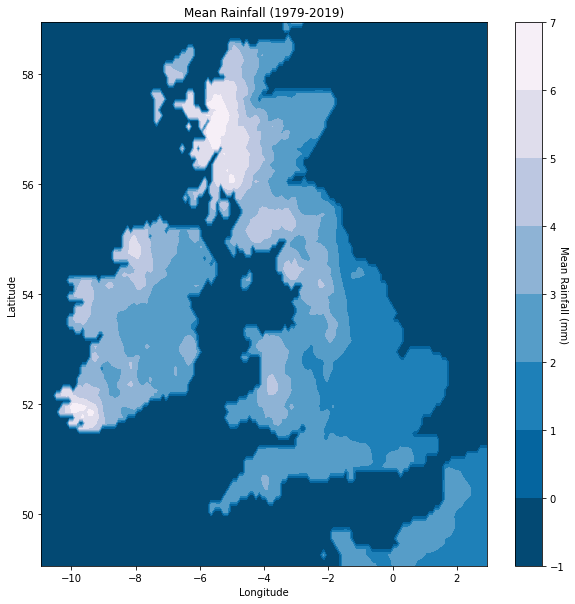

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
cs = ax.contourf(longitude[:], latitude[:], mean_rainfall, cmap=cm.PuBu_r)

cbar = fig.colorbar(cs)
cbar.set_label('Mean Rainfall (mm)', rotation=270)

plt.title("Mean Rainfall (1979-2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

__Max Rainfall__

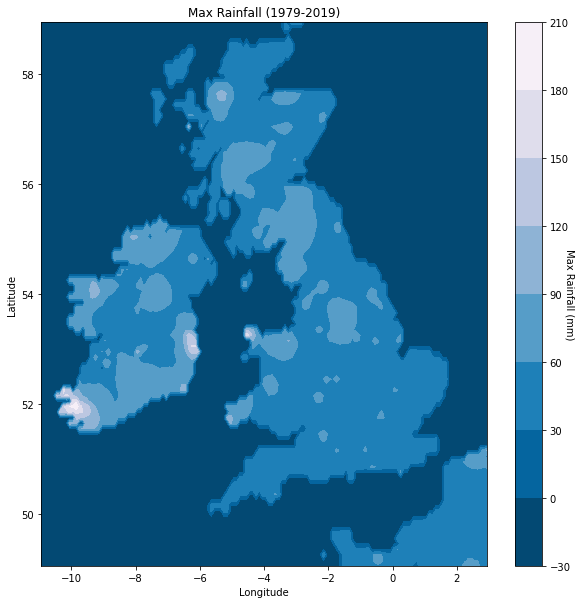

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
cs = ax.contourf(longitude[:], latitude[:], max_rainfall, cmap=cm.PuBu_r)

cbar = fig.colorbar(cs)
cbar.set_label('Max Rainfall (mm)', rotation=270)

plt.title("Max Rainfall (1979-2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

__Finding mean rainfall per year__

In [27]:
ds["rr"]["time"]

<xarray.DataArray 'time' (time: 14822)>
array(['1979-01-01T00:00:00.000000000', '1979-01-02T00:00:00.000000000',
       '1979-01-03T00:00:00.000000000', ..., '2019-07-29T00:00:00.000000000',
       '2019-07-30T00:00:00.000000000', '2019-07-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-07-31
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time in days

In [28]:
ds['year'] = ds['rr']["time"].dt.year

In [29]:
years = np.arange(1979, 2020, 1)
mean_rainfall_per_year = []

for i in range(len(years)):
    Bool_year = ds["year"]==years[i]
    mean_rainfall_per_year.append(np.average(rain_mask[Bool_year], axis=0))
mean_rainfall_per_year = np.array(mean_rainfall_per_year)
mean_rainfall_per_year.shape

(41, 100, 140)

So now we have $41$ rainfall maps, one for each year!

__Animating the mean rainfall per year__

Useful info [here](https://stackoverflow.com/questions/48228692/maintaining-one-colorbar-for-maptlotlib-funcanimation).

<IPython.core.display.Javascript object>


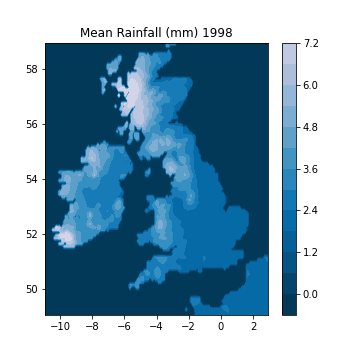

In [44]:
fig, ax = plt.subplots(figsize=(5,5))


# The maximum mean rainfall for the period 1979-2029 is 8.8
rain_max = np.max(mean_rainfall_per_year)+1.2
rain_min = np.min(mean_rainfall_per_year)
Levels = 12


cs = ax.contourf(longitude[:], latitude[:], mean_rainfall_per_year[0], cmap=plt.cm.PuBu_r,\
                 levels=Levels, vmin=rain_min, vmax=rain_max)

cbar = plt.colorbar(cs)

plt.xlabel("Longitude")
plt.ylabel("Latitude")

 
def animate(i):
    ax.clear()
    cs = ax.contourf(longitude[:], latitude[:], mean_rainfall_per_year[i], cmap=plt.cm.PuBu_r,\
                   levels=Levels, vmin=rain_min, vmax=rain_max)
    #cbar = fig.colorbar(cs)
    plt.title("Mean Rainfall (mm) {}".format(years[i]))
    #return ax

    
anim = FuncAnimation(fig, animate, interval=600, frames=len(years))
 
plt.show()

For some contours options, check [[here]](https://stackoverflow.com/questions/39922504/missing-levels-in-python-contour-plot) - python shows contours only when there are values on both sides of the level.

__Adding the cities we're going to study on the plot__

We start by defining the cities-coordinates map [Latitude, Longitude]:

In [7]:
cities_map = {
            "London": [51.5074, -0.1278],
            "Cardiff": [51.4816 + 0.15, -3.1791 -0.05],
            "Glasgow": [55.8642,  -4.2518],
            "Lancaster":[54.466, -2.8007],
            "Bradford": [53.7960, -1.7594],
            "Manchester":[53.4808, -2.2426],
            "Birmingham":[52.4862, -1.8904],
            "Liverpool":[53.4084 , -2.9916 +0.1 ],
            "Leeds":[ 53.8008, -1.5491 ],
            "Edinburgh": [55.9533, -3.1883],
            "Belfast": [54.5973, -5.9301],
            "Dublin": [53.3498, -6.2603],
            "LakeDistrict":[54.4500,-3.100],
            "Newry":[54.1751, -6.3402],
            "Preston":[53.7632, -2.7031 ],
            "Truro":[50.2632, -5.0510],
            "Bangor":[54.2274 - 0, -4.1293 - 0.3],
            "Plymouth":[50.3755 + 0.1, -4.1427],
            "Norwich": [52.6309, 1.2974],
            "StDavids":[51.8812+0.05, -5.2660+0.05] ,
            "Swansea":[51.6214+0.05,-3.9436],
            "Lisburn":[54.5162,-6.058],
            "Salford":[53.4875, -2.2901],
            "Aberdeen":[57.1497,-2.0943-0.05],
            "Stirling":[56.1165, -3.9369],
            "Hull":[53.7676+0.05, 0.3274]
            }

We list the longitude and latitude of each:

In [46]:
long_cities = []
lat_cities = []

for i in cities_map:
    lat_cities.append(cities_map[i][0])
    long_cities.append(cities_map[i][1])

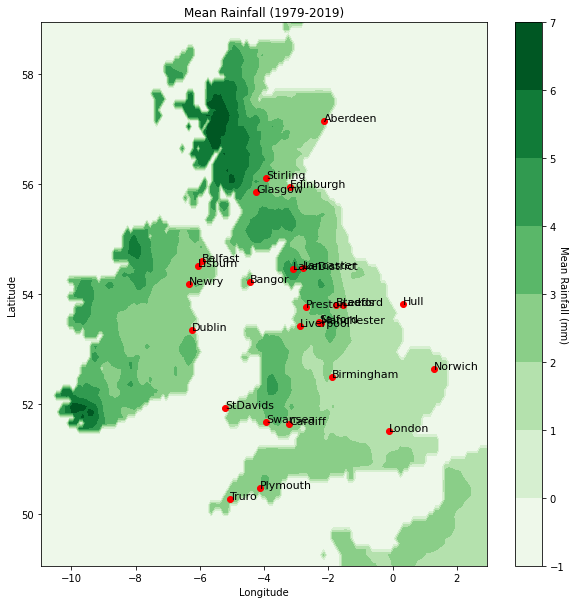

In [49]:
# We initially list the cities' names
names = list(cities_map.keys())

fig, ax = plt.subplots(figsize=(10,10))
cs = ax.contourf(longitude[:], latitude[:], mean_rainfall, cmap=cm.Greens) #PuBu_r

plt.scatter(long_cities, lat_cities, color='r')

for i, txt in enumerate(names):
    plt.annotate(txt, (long_cities[i], lat_cities[i]), size=11)

cbar = fig.colorbar(cs)
cbar.set_label('Mean Rainfall (mm)', rotation=270)

plt.title("Mean Rainfall (1979-2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

>⚠️ __Note__: We see that two cities (Hull & St. Davids) have wrong coordinates. This would be important below.

__Rainfall per city__

Now we're going to plot the rainfall timeseries in each city. 

- We don't have in the long/lat data, exactly the position of each city, so we have first to find the closest coordinates where we have data.
- We then find the indices in the longitude/latitude arrays that correspond to these values. This will be helpfull to extract the rainfall data later.

In [50]:
long_indices = []
lat_indices = []

for i in range(len(cities_map)):
    # We subtract the cities coordinates from the standard coordinates
    # then we find the minimum value, that corresponds to the closest distance
    dif_array_long = np.abs(longitude[:]-long_cities[i])
    dif_array_lat = np.abs(latitude[:]-lat_cities[i])
    long_min = np.min(np.abs(longitude[:]-long_cities[i]))
    lat_min = np.min(np.abs(latitude[:]-lat_cities[i]))
    long_indices.append(np.argwhere(dif_array_long==long_min)[0])
    lat_indices.append(np.argwhere(dif_array_lat==lat_min)[0])
    
print("Sanity check: Len indices is:", len(long_indices), "and len cities is:", len(cities_map))
print("Sanity check: Len indices is:", len(lat_indices), "and len cities is:", len(cities_map))

Sanity check: Len indices is: 26 and len cities is: 26
Sanity check: Len indices is: 26 and len cities is: 26


Now we are ready to plot the rainfall timeseries for each location. We choose the indices we found before, as keys, to extract the most relevant rainfall data.

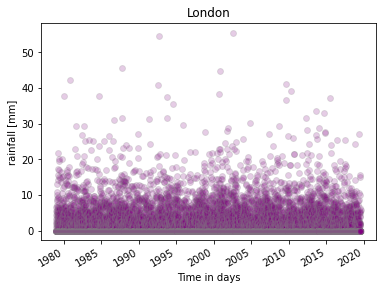

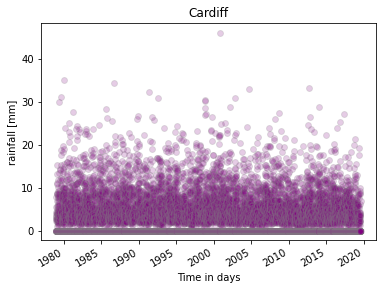

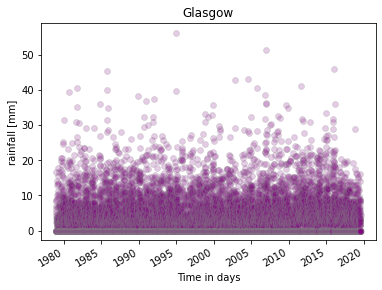

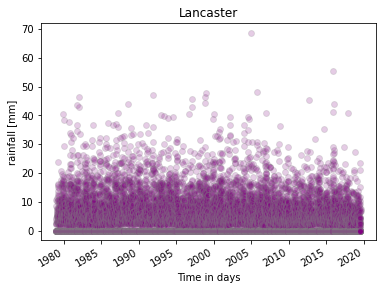

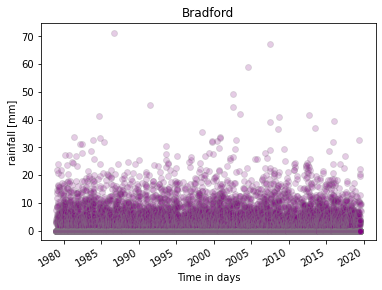

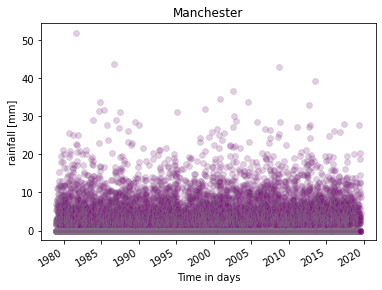

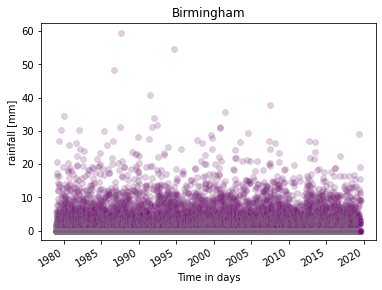

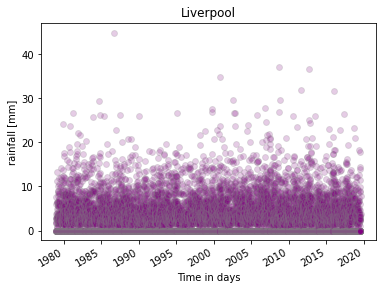

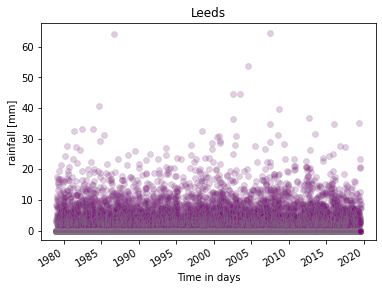

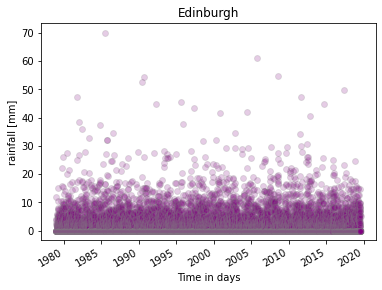

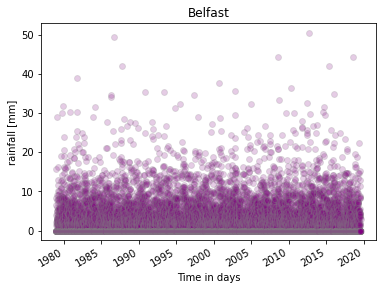

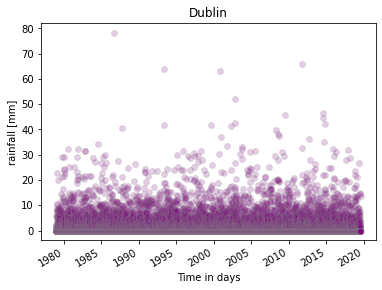

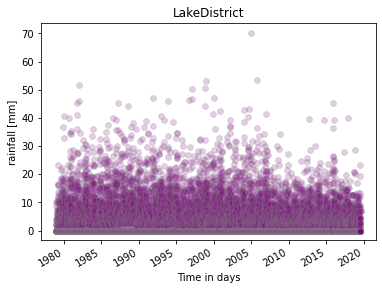

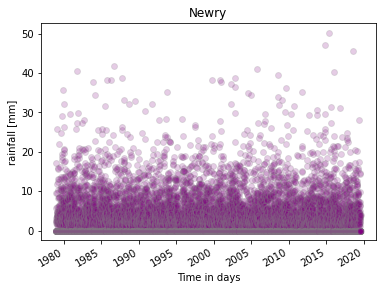

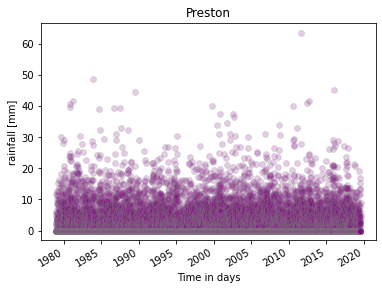

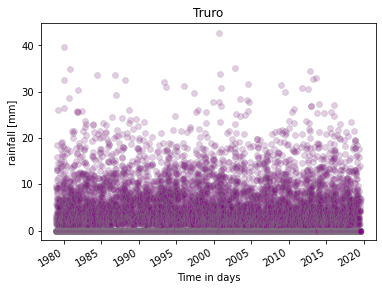

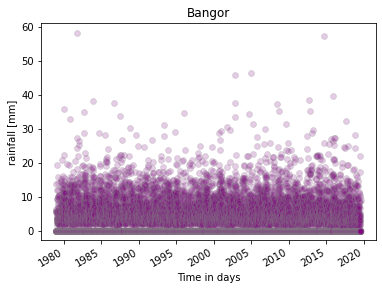

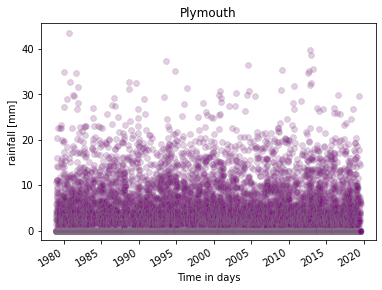

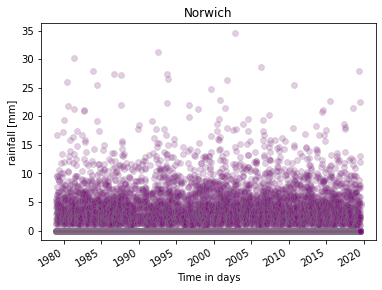

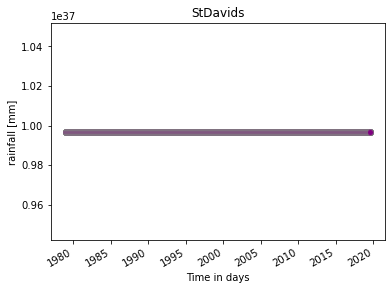

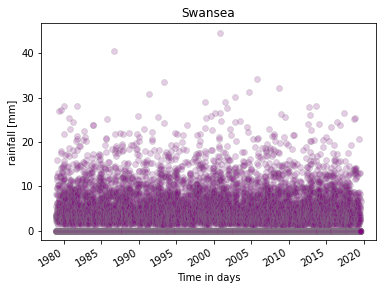

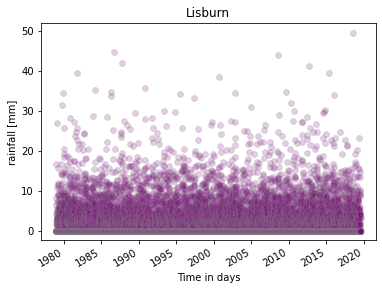

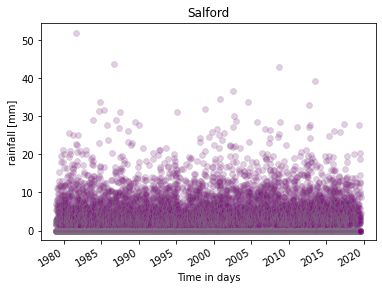

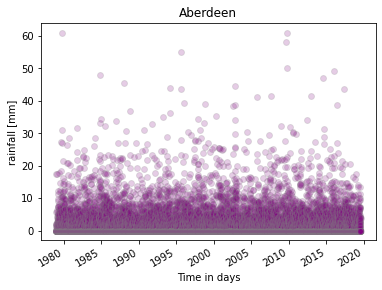

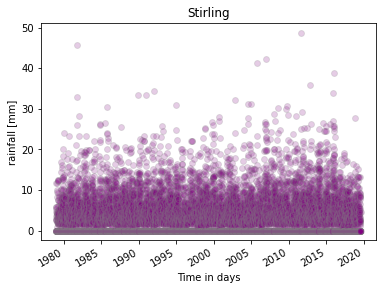

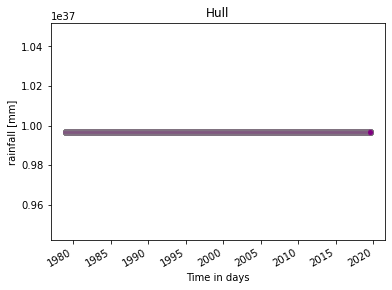

In [51]:
for i in range(len(cities_map)):
    key_long = long_indices[i]
    key_lat = lat_indices[i]
    long = ds["rr"]["longitude"].values[key_long][0]
    lat = ds["rr"]["latitude"].values[key_lat][0]
    one_point = ds["rr"].sel(latitude=lat,longitude=long)
    one_point.plot.line(hue='lat', marker="o", color="grey",
                    markerfacecolor="purple", alpha=0.2, linestyle = 'None')
    plt.title(list(cities_map.keys())[i])
    plt.show()

__Note__: As we mentioned above, only two cities have "problems", and this is due to the wrong coordinates used above. Will need to fix.

__Info for Cardiff only__

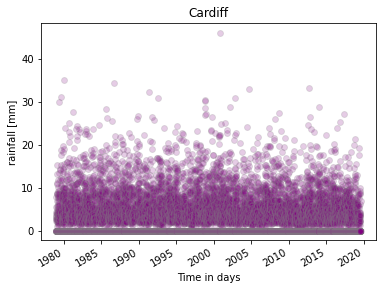

In [30]:
i=1
key_long = long_indices[i]
key_lat = lat_indices[i]
long = ds["rr"]["longitude"].values[key_long][0]
lat = ds["rr"]["latitude"].values[key_lat][0]
one_point = ds["rr"].sel(latitude=lat,longitude=long)
one_point.plot.line(hue='lat', marker="o", color="grey",
                markerfacecolor="purple", alpha=0.2, linestyle = 'None')
plt.title(list(cities_map.keys())[i])
plt.show()

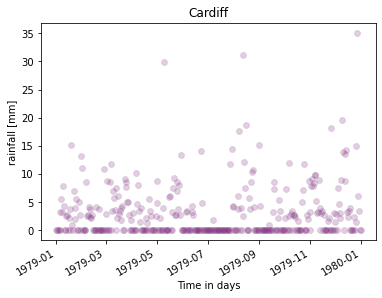

In [37]:
Bool_year = ds["year"] == 1979
data_Cardiff_1979 = ds["rr"][Bool_year]
one_point = data_Cardiff_1979.sel(latitude=lat,longitude=long)
one_point.plot.line(hue='lat', marker="o", color="grey",
                markerfacecolor="purple", alpha=0.2, linestyle = 'None')
plt.title(list(cities_map.keys())[i])
plt.show()

In [39]:
np.save("rainfall_Cardiff_1979.npy", one_point)

### Automated City/Time selection

The functions below, allow to:

    1 - Find specific coordinates of each city, and the relevant indices in the Long/Lat arrays
    2 - Choose time intervals (for 1 year, choose same start & end date) and plot rainfalls there
    3 - Return an array with rainfall data for that period

In [8]:
def city_coordinates(city_name, long_coord, lat_coord):
    long_city = cities_map[city_name][1]
    lat_city = cities_map[city_name][0]

    # We subtract the cities coordinates from the standard coordinates
    # then we find the minimum value, that corresponds to the closest distance
    dif_array_long = np.abs(long_coord[:]-long_city)
    dif_array_lat = np.abs(lat_coord[:]-lat_city)
    long_min = np.min(dif_array_long)
    lat_min = np.min(dif_array_lat)
    long_index = np.argwhere(dif_array_long==long_min)[0]
    lat_index = np.argwhere(dif_array_lat==lat_min)[0]
    
    return long_index[0], lat_index[0], long_city, lat_city

In [9]:
def rainfall_city_time(city_name, long_coord, lat_coord, time_start, time_end):
    long_key , lat_key, _, _ = city_coordinates(city_name, long_coord, lat_coord)
    long = longitude[long_key]
    lat = latitude[lat_key]
    data_city = ds["rr"].sel(latitude=lat, longitude=long)
    data_city = data_city.sel(time=slice("{}-01-01".format(time_start), "{}-12-31".format(time_end)))
    data_city.plot.line(hue='lat', marker="o", color="grey",\
                    markerfacecolor="purple", alpha=0.2, linestyle = 'None')
    plt.title("{}".format(city_name))
    plt.show()
    return data_city

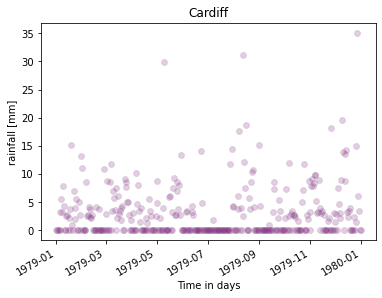

In [10]:
Rainfall_Cardiff = rainfall_city_time("Cardiff", longitude, latitude, 1979, 1979)

In [11]:
np.shape(Rainfall_Cardiff)

(365,)

# Opening the dataset in chuncks

<div class="alert alert-block alert-info">
    
<b>Note:</b> Under development.</div>

The large datasets can be quite heavy for memory, but xarrays are loading only what necessary, without computing "a priori" stuff. You can also break data in "time chuncks". Useful links: [[One]](http://xarray.pydata.org/en/stable/user-guide/io.html#opendap), [[Two]](http://xarray.pydata.org/en/stable/user-guide/dask.html#dask), [[Three]](https://examples.dask.org/xarray.html), [[Four]](https://stackoverflow.com/questions/46951981/create-and-write-xarray-dataarray-to-netcdf-in-chunks)

We are now loading the $6$ model fields data:

In [ ]:
model_fields_dataset = "model_fields_1979-2019.nc"
model_fields = xr.open_dataset(model_fields_dataset)

# model_fields_HD_dataset = "model_fields_linearly_interpolated_1979-2019.nc"
# model_fields_HD = xr.open_dataset(model_fields_HD_dataset)

C:\Users\klera\Anaconda3\lib\site-packages\xarray\coding\times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [109]:
model_fields

<xarray.Dataset>
Dimensions:                      (latitude: 20, longitude: 21, time: 59900)
Coordinates:
  * time                         (time) object 34368-03-15 00:00:00 ... 18196...
  * latitude                     (latitude) float64 59.45 58.89 ... 49.44 48.89
  * longitude                    (longitude) float64 -12.5 -11.67 ... 4.167
Data variables:
    geopotential                 (time, latitude, longitude) float64 ...
    y_wind                       (time, latitude, longitude) float64 ...
    x_wind                       (time, latitude, longitude) float64 ...
    unknown_local_param_137_128  (time, latitude, longitude) float64 ...
    unknown_local_param_133_128  (time, latitude, longitude) float64 ...
    air_temperature              (time, latitude, longitude) float64 ...

In this dataset, we have:

- The time is loaded in a weird format, so we need to transform it below
- The latitude/longitude arrays are more sparse than the ones of the rainfall data above, so need to be changed
- We have 6 model fields: 

    1) geopotential, <br> 
    2) y_wind_speed, <br>
    3) x_wind_speed, <br>
    4) total_column_water_vapour, <br>
    5) specific_humidity, <br>
    6) air_temperature.

In [ ]:
longitude = model_fields["longitude"].values
latitude = model_fields["latitude"].values

#### 1 - Fixing the time coordinates

We know that the period covered is between $1979-2019$ and the sampling happens every $6H$. We are using pandas to create "physical" timesteps with the above properties and re-write the time information based on these.

Let's start by checking the length of our "times" coordinate:

In [111]:
dt = model_fields["time"]
len(dt)

59900

As a sanity check, we need to create a "physical" time array, of the same length.

Due to pandas "date_range" function, when doing the sampling, we need to extend to the start of $2020$, and then ignore the last day,

In [ ]:
dt_phys = pd.date_range('1979-01-01', '2020-01-01', freq='6H')[:-1]

In [113]:
len(dt_phys)

59900

These are of the same length, so we can now pass the new time coordinates to our `model_fields` xarray.

In [ ]:
model_fields["time"] = dt_phys

In [162]:
model_fields["time"]

<xarray.DataArray 'time' (time: 59900)>
array(['1979-01-01T00:00:00.000000000', '1979-01-01T06:00:00.000000000',
       '1979-01-01T12:00:00.000000000', ..., '2019-12-31T06:00:00.000000000',
       '2019-12-31T12:00:00.000000000', '2019-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2019-12-31T18:00:00

As a next step, we want values of the fields/day, so we want to take the mean value of the fields, within each day.

Let's first keep only data for $1979$ as an example:

In [153]:
mf_time_slice = model_fields.sel(time=slice("1979-01-01", "1989-12-31"))

In [154]:
mf_time_slice["time"]

<xarray.DataArray 'time' (time: 16072)>
array(['1979-01-01T00:00:00.000000000', '1979-01-01T06:00:00.000000000',
       '1979-01-01T12:00:00.000000000', ..., '1989-12-31T06:00:00.000000000',
       '1989-12-31T12:00:00.000000000', '1989-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 1989-12-31T18:00:00

In [157]:
len(mf_time_slice["time"])/4, len(mf_time_slice["time"])%4, int(len(mf_time_slice["time"])/4)

(4018.0, 0, 4018)

The easier way would be to define specific series of the model fields

In [126]:
key_long_Card, key_lat_Card, _, _ = city_coordinates("Cardiff", longitude, latitude)

In [128]:
mf_time_slice = mf_time_slice.sel(latitude=latitude[key_lat_Card], longitude=longitude[key_long_Card])

In [129]:
mf_time_slice

<xarray.Dataset>
Dimensions:                      (time: 1460)
Coordinates:
  * time                         (time) datetime64[ns] 1979-01-01 ... 1979-12...
    latitude                     float64 51.67
    longitude                    float64 -3.333
Data variables:
    geopotential                 (time) float64 ...
    y_wind                       (time) float64 ...
    x_wind                       (time) float64 ...
    unknown_local_param_137_128  (time) float64 ...
    unknown_local_param_133_128  (time) float64 ...
    air_temperature              (time) float64 ...

In [130]:
geopotential = mf_time_slice["geopotential"].values
y_wind = mf_time_slice["y_wind"].values
x_wind = mf_time_slice["x_wind"].values
water_vapour = mf_time_slice["unknown_local_param_137_128"].values
humidity = mf_time_slice["unknown_local_param_133_128"].values
air_temperature = mf_time_slice["air_temperature"].values

We find the average of the fields per day

In [132]:
geopotential_timeseries = np.average(geopotential.reshape((365,4)), axis=1)
y_wind_timeseries = np.average(y_wind.reshape((365,4)), axis=1)
x_wind_timeseries = np.average(x_wind.reshape((365,4)), axis=1)
water_vapour_timeseries = np.average(water_vapour.reshape((365,4)), axis=1)
humidity_timeseries = np.average(humidity.reshape((365,4)), axis=1)
air_temperature_timeseries = np.average(air_temperature.reshape((365,4)), axis=1)

## Automate geophysical data collection per city/time

In [ ]:
def geophysical_city_time(city_name, long_coord, lat_coord, time_start, time_end):
    long_key , lat_key, _, _ = city_coordinates(city_name, long_coord, lat_coord)
    long = longitude[long_key]
    lat = latitude[lat_key]
    
    
    mf_time_slice = model_fields.sel(time=slice("{}-01-01".format(time_start), "{}-12-31".format(time_end)))
    mf_time_slice = mf_time_slice.sel(latitude=latitude[lat_key], longitude=longitude[long_key])
    time_points = len(mf_time_slice["time"])
    if time_points%4 != 0:
        print("Error in days")
    else:
        days = time_points//4 #since we have 4 time points per day. We need int for the arrays below.
    
    ### Reading the model fields in the specific time slice 
    geopotential = mf_time_slice["geopotential"].values
    y_wind = mf_time_slice["y_wind"].values
    x_wind = mf_time_slice["x_wind"].values
    water_vapour = mf_time_slice["unknown_local_param_137_128"].values
    humidity = mf_time_slice["unknown_local_param_133_128"].values
    air_temperature = mf_time_slice["air_temperature"].values
    
    ### Finding the average fields values per day
    geopotential_timeseries = np.average(geopotential.reshape((days,4)), axis=1)
    y_wind_timeseries = np.average(y_wind.reshape((days,4)), axis=1)
    x_wind_timeseries = np.average(x_wind.reshape((days,4)), axis=1)
    water_vapour_timeseries = np.average(water_vapour.reshape((days,4)), axis=1)
    humidity_timeseries = np.average(humidity.reshape((days,4)), axis=1)
    air_temperature_timeseries = np.average(air_temperature.reshape((days,4)), axis=1)
    
    time_range = pd.date_range("{}-01-01".format(time_start), "{}-12-31".format(time_end), freq='1D')
    
    ### Putting them all together
    # We return 6 model fields (each row of X denotes a field, with legth - N columns - depending on the number of days)
    X = np.vstack((geopotential_timeseries, y_wind_timeseries, x_wind_timeseries, water_vapour_timeseries, humidity_timeseries, air_temperature_timeseries))
    
    # Calculating transpose such that each row corresponds for a day
    # X dimensions (days, model_fields) 
    X = X.T
    
    ### Calculating windspeed and consider that as a variable (we use that, instead of x_wind/y_wind)
    ### After adding the windspeed, our fields are:
    # 0: geopotential
    # 1: water_vapour
    # 2: humidity
    # 3: air_temperature
    # 4: windspeed
    X = np.concatenate((X[:,[0,3,4,5]],np.sqrt(pow(X[:,1],2)+pow(X[:,2],2)).reshape(-1,1)), axis=1)
    
    
    
    ### Standardize data (making each column having 0 mean and stdev 1)
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    
    return X, time_range

In [ ]:
X_Cardiff, time_period = geophysical_city_time("Cardiff", longitude, latitude, 1979, 1979)

In [ ]:
plt.plot(time_period, X_Cardiff[:,4])
plt.show()

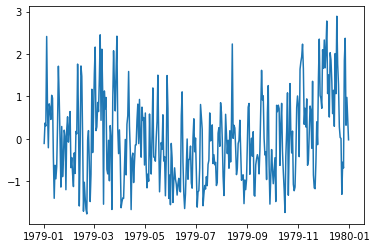

In [191]:
plt.plot(time_period, X_Cardiff[:,4])
plt.show()

Saving the data:

In [31]:
np.save("model_fields_Cardiff.npy", X)

# Correlation functions

<div class="alert alert-block alert-info">
    
<b>Note:</b> Under development.</div>

In [2]:
# Create a random box

np.random.seed(seed=1)

N = 10000 #N number of particles
Dimensions = 2
box_size = 20

coordinates = np.random.rand(N,Dimensions)*box_size

<IPython.core.display.Javascript object>


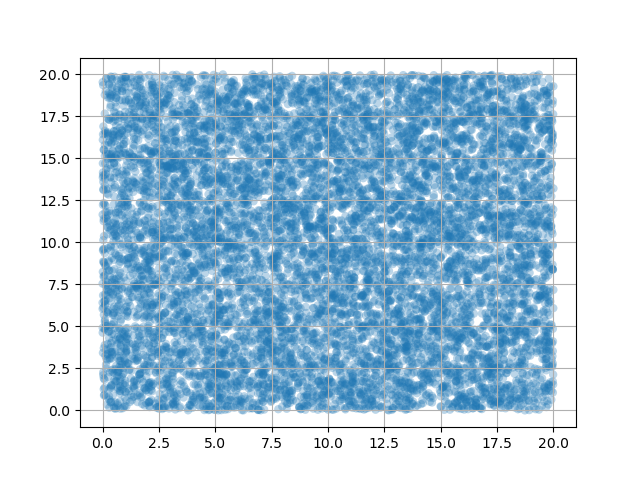

In [3]:
fig, ax = plt.subplots()
ax.scatter(coordinates[:,0], coordinates[:,1], alpha=0.3, edgecolors='none')

ax.grid(True)

plt.show()

In [7]:
### Cutting a sphere from the simulation data ###

def radial_bin_cut(cent, radi_min, radi_max, coord):
    """ Function that reads the centre and radius of the sphere and collects all the particles/haloes inside. """
    cut = coord-cent
    norms = LA.norm(cut, axis=1)
    bool_box = (norms >= radi_min) & (norms <= radi_max)
    coord_box = coord[bool_box] #-cent
    
    return coord_box

In [8]:
radial_cell = radial_bin_cut(np.array([5,5]), 0.5, 0.7, coordinates)

<IPython.core.display.Javascript object>


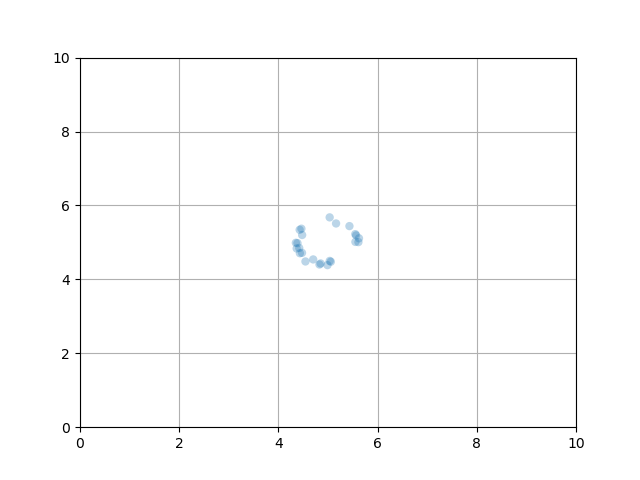

In [9]:
fig, ax = plt.subplots()
ax.scatter(radial_cell[:,0], radial_cell[:,1], alpha=0.3, edgecolors='none')

ax.grid(True)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
plt.show()

In [10]:
len(radial_cell)

68

In [10]:
def number_per_cell(cent, radi_min, radi_max, coord):
    rad_cell = radial_bin_cut(cent, radi_min, radi_max, coord)
    N_part = len(rad_cell)
    N_part = N_part/(np.pi*(radi_max**2-radi_min**2))
    return N_part/(N/box_size**2)

In [11]:
print(number_per_cell(np.array([5,5]), 0.5, 0.7, coordinates))

1.273239544735163


In [12]:
N/box_size**2*2*np.pi*0.5*0.7

54.97787143782138

In [13]:
r = np.arange(0.5, 3, 0.1)
points = np.random.randint(3, 16, (35,2))

In [14]:
points, r

(array([[10,  7],
        [13,  5],
        [ 4,  8],
        [ 6, 14],
        [15, 10],
        [ 9, 13],
        [12,  6],
        [12, 12],
        [ 6,  5],
        [14,  3],
        [13, 14],
        [ 4, 14],
        [ 4,  6],
        [ 4, 10],
        [12,  4],
        [13, 15],
        [13,  9],
        [ 9, 10],
        [15, 14],
        [ 5,  7],
        [11,  9],
        [ 3, 12],
        [15,  4],
        [15, 11],
        [ 5, 13],
        [15, 13],
        [ 4, 14],
        [ 6,  6],
        [11,  7],
        [ 9, 10],
        [ 3,  3],
        [ 3,  6],
        [ 8,  5],
        [11,  5],
        [14, 10]]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
        1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9]))

In [15]:
g = np.zeros((len(r), len(points)))

for j in range(len(points)):
    for i in range(len(r)):
#         fig, ax = plt.subplots()
#         ax.scatter(radial_bin_cut(points[j], r[i], r[i]+0.2, coordinates)[:,0],\
#                    radial_bin_cut(points[j], r[i], r[i]+0.2, coordinates)[:,1],\
#                    alpha=0.3, edgecolors='none')

#         ax.grid(True)
#         ax.set_xlim(0,10)
#         ax.set_ylim(0,10)
#         plt.show()
        g[i,j]=number_per_cell(points[j], r[i], r[i]+0.1, coordinates)

g = g-1

In [66]:
g, np.mean(g, axis=1)

(array([[-0.00426138, -0.03690855, -0.00426138, -0.12668826,  0.04470937,
          0.04470937, -0.00426138,  0.14265087, -0.00426138, -0.14301184,
          0.18345983,  0.14265087,  0.0120622 ,  0.00390041, -0.00426138,
          0.15081267, -0.03690855,  0.0120622 , -0.00426138,  0.02838579,
         -0.00426138,  0.14265087, -0.15117364,  0.18345983, -0.13485005],
        [-0.03948596, -0.15117364, -0.03948596, -0.01714842,  0.03311103,
          0.03311103,  0.09453926, -0.08974541, -0.03948596, -0.05623911,
         -0.06740788, -0.08974541, -0.05065473,  0.01635788, -0.03948596,
         -0.08974541, -0.15117364, -0.05065473,  0.09453926,  0.13362995,
         -0.03948596, -0.08974541,  0.07220172, -0.06740788, -0.04507034],
        [ 0.0143475 , -0.03658208,  0.0143475 , -0.066291  , -0.05355861,
         -0.05355861, -0.07477926, -0.03233795,  0.0143475 , -0.00687316,
          0.1077184 , -0.03233795,  0.05678882,  0.15015972,  0.0143475 ,
         -0.01536142, -0.03658208,  

<IPython.core.display.Javascript object>


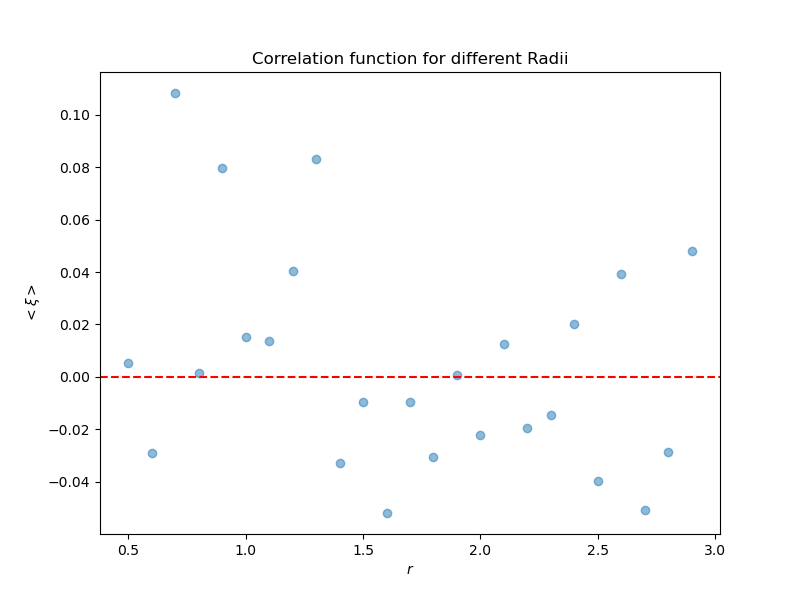

In [16]:
plt.figure(figsize=(8,6))

plt.scatter(r, np.mean(g, axis=1), alpha=0.5)
plt.axhline(y=0, ls = '--', c='r')
plt.title("Correlation function for different Radii")
plt.xlabel(r'$r$')
plt.ylabel(r"$<\xi>$")
plt.show()

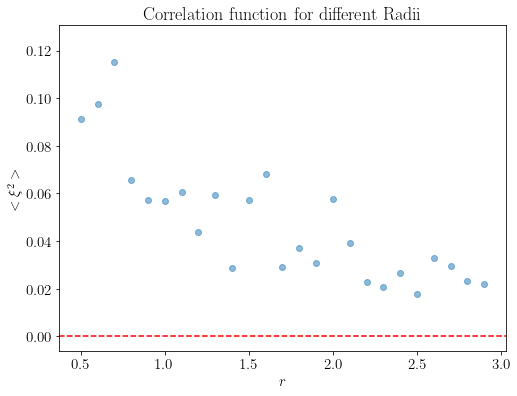

In [82]:
plt.figure(figsize=(8,6))

plt.scatter(r, np.mean(g**2, axis=1), alpha=0.5)
plt.axhline(y=0, ls = '--', c='r')
plt.title("Correlation function for different Radii")
plt.xlabel(r'$r$')
plt.ylabel(r"$<\xi^2>$")
plt.show()

__Random & Correlated distributions__

In [17]:
N = 20
random_square = np.random.randint(2, size=(N, N))
random_square;

In [18]:
np.sum(random_square==1)

191

In [19]:
random_square[random_square==0]=-1

Create with constrained number of $0$ and $1$, similar to entanglement features.

In [20]:
ones = np.ones(N**2//2)
zeros = np.zeros(N**2//2)
random_square = np.hstack((ones, zeros))
np.random.shuffle(random_square)
random_square[random_square==0]=-1
random_square.reshape((N, N));

In [21]:
np.sum(random_square==1)==np.sum(random_square==-1)

True

In [22]:
box_size = N+1

x_grid = np.arange(0, box_size, 1) 
y_grid = np.arange(0, box_size, 1)

# Create the grid mesh

mesh = np.array(np.meshgrid(x_grid[1:], y_grid[1:])) # Create two arrays that are combined to give the grid - Shape (2,Ngr-1,Ngr-1)
mesh = np.concatenate(mesh.T, axis=0)

<IPython.core.display.Javascript object>


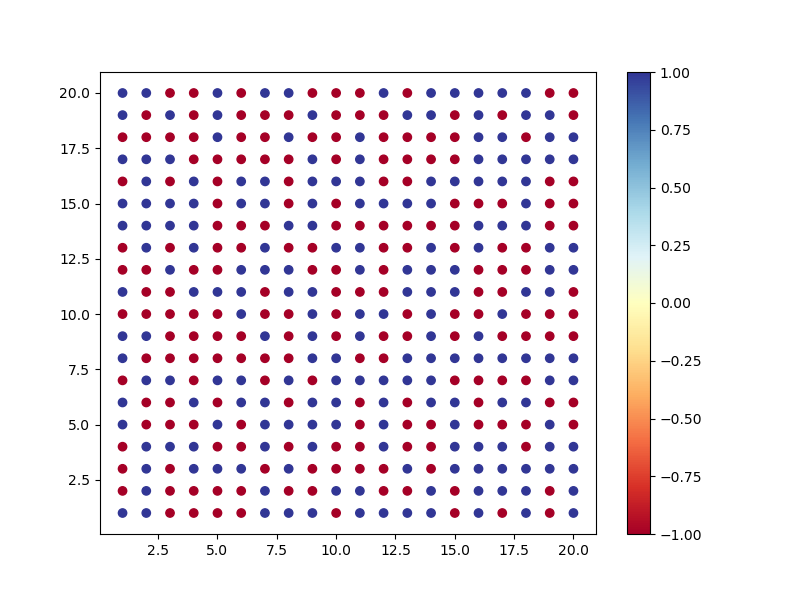

In [23]:
cm = plt.cm.get_cmap('RdYlBu')

plt.figure(figsize=(8,6))
number_plot = plt.scatter(mesh.T[0], mesh.T[1] ,c=np.ravel(random_square, order='F'), cmap=cm)
plt.colorbar(number_plot)
plt.show()

In [24]:
values_array = np.ravel(random_square, order='F')

In [25]:
x_coor = mesh.T[0][values_array>0]
y_coor = mesh.T[1][values_array>0]
coord = np.vstack((x_coor, y_coor)).T

In [26]:
coord;

<IPython.core.display.Javascript object>


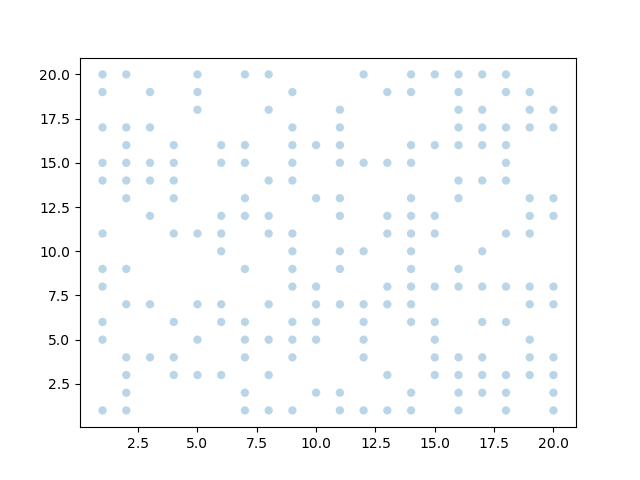

In [27]:
fig, ax = plt.subplots()
ax.scatter(coord[:,0], coord[:,1], alpha=0.3, edgecolors='none')

#ax.grid(True)

plt.show()

In [28]:
r = np.arange(0.5, 2, 0.1)
points = np.random.randint(3, 16, (10,2))

In [29]:
g = np.zeros((len(r), len(points)))

for j in range(len(points)):
    for i in range(len(r)):
        g[i,j]=number_per_cell(points[j], r[i], r[i]+0.1, coord)

g = g-1

<IPython.core.display.Javascript object>


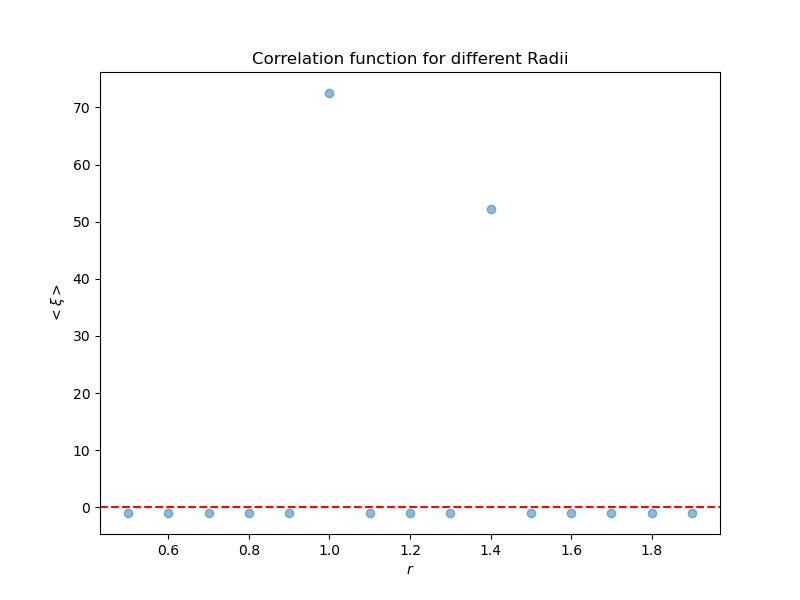

In [30]:
plt.figure(figsize=(8,6))

plt.scatter(r, np.mean(g, axis=1), alpha=0.5)
plt.axhline(y=0, ls = '--', c='r')
plt.title("Correlation function for different Radii")
plt.xlabel(r'$r$')
plt.ylabel(r"$<\xi>$")
#plt.ylim((-2,1))
plt.show()

<IPython.core.display.Javascript object>


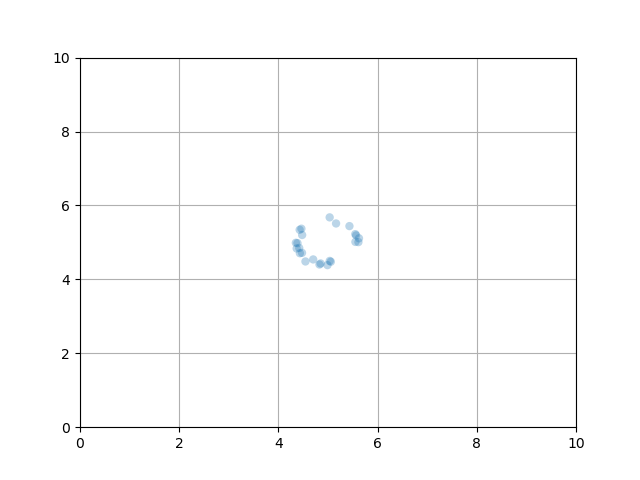

In [31]:
fig, ax = plt.subplots()
ax.scatter(radial_cell[:,0], radial_cell[:,1], alpha=0.3, edgecolors='none')

ax.grid(True)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
plt.show()

In [32]:
g = np.zeros((len(r), len(points)))

for j in range(len(points)):
    for i in range(len(r)):
        g[i,j]=number_per_cell(points[j], r[i], r[i]+0.1, radial_cell)

g = g-1

<IPython.core.display.Javascript object>


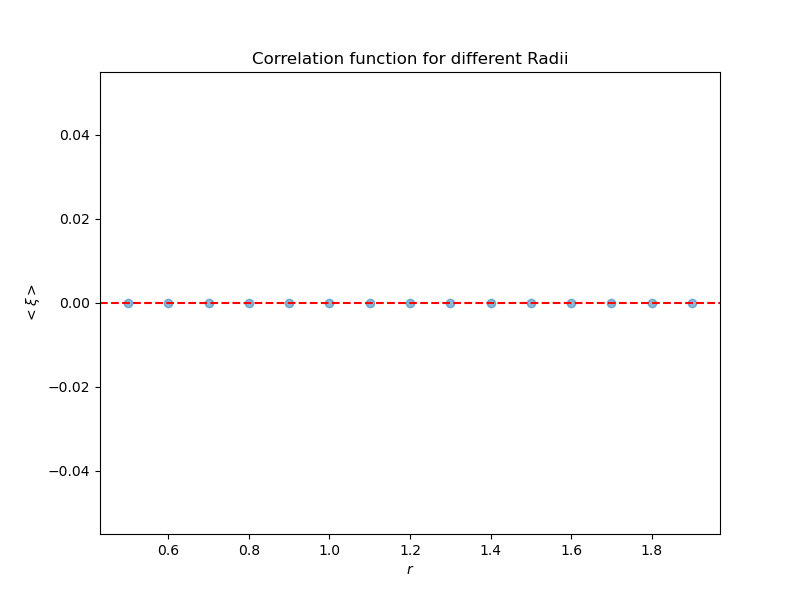

In [33]:
plt.figure(figsize=(8,6))

plt.scatter(r, np.log10(np.abs(np.mean(g, axis=1))), alpha=0.5)
plt.axhline(y=0, ls = '--', c='r')
plt.title("Correlation function for different Radii")
plt.xlabel(r'$r$')
plt.ylabel(r"$<\xi>$")
plt.show()